# what is mtcnn

이미지 상에서 얼굴의 bbox와 5개의 랜드마크를 detection하는 알고리즘
- Non-max suppression을 사용
<br>

1. image pyramid을 만들기 위해 input image을 여러 번 scaled down<br>
각 scale의 image들이 CNN을 거친다.
2. CNN을 거친 각각의 이미지에서 bbox에 대한 이미지 패치(image patches)을 추출한다.
3. 이미지 패치를 stage2에서는 24x24, stage3에서는 48x48로 resize을 한다.
4. 그리고 그놈들을 CNN에 넣는다.
5. stage3에서는 bbox와 scores 이외에도 각 bbox에 대한 5개의 얼굴 랜드마크를 계산한다.

# dataset Prepare

In [ ]:
import glob
import random
import os

In [ ]:
data_path = 'data\image\car_license_plate\plate1\detect_recog_image'

image_path_list = glob.glob(data_path + '/*.jpg')

# train : test = 7:3
data_n = len(image_path_list)

train_idx_list = np.random.choice(data_n, int(data_n*0.7), replace = False)
test_idx_list = np.setdiff1d(np.arange(data_n), train_idx_list)

print(len(train_idx_list), len(test_idx_list))

In [ ]:
for i in train_idx_list:
    img_path = image_path_list[i]
    img_name = img_path.split('\\')[-1]
    print(img_path, img_name)
    os.rename(img_path, data_path + '/train/' + img_name)
    

for j in test_idx_list:
    img_path = image_path_list[j]
    img_name = img_path.split('\\')[-1]
    print(img_path, img_name)
    os.rename(img_path, data_path + '/test/' + img_name)

# Dataset

In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
#from facenet_pytorch import MTCNN
import torch
import torchvision
import numpy as np
import pandas as pd
import glob
import cv2
import matplotlib.pyplot as plt

from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

## Meta Data

In [3]:
data_path = 'data\image\car_license_plate\plate1\detect_recog_image'

bbox_frame = pd.read_csv(data_path+'/plate1.csv')
print(bbox_frame.shape)
bbox_frame = bbox_frame[['name', 'x', 'y', 'w', 'h', 'x_size', 'y_size', 'text']]
bbox_frame.head()

(444, 8)


,name,x,y,w,h,x_size,y_size,text
0,AYO9034.jpg,528,412,162,52,1280,720,AYO9034
1,AZJ6991.jpg,560,642,236,76,1280,1280,AZJ6991
2,FZB9581.jpg,967,493,258,83,1280,1280,FZB9581
3,GWT2180.jpg,529,308,227,73,1280,719,GWT2180
4,HPM9362.jpg,584,673,259,84,1280,960,HPM9362


In [4]:
bbox_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 444 entries, 0 to 443
Data columns (total 8 columns):
name      444 non-null object
x         444 non-null int64
y         444 non-null int64
w         444 non-null int64
h         444 non-null int64
x_size    444 non-null int64
y_size    444 non-null int64
text      444 non-null object
dtypes: int64(6), object(2)
memory usage: 27.8+ KB


In [5]:
bbox_frame.describe()

,x,y,w,h,x_size,y_size
count,444.000000,444.000000,444.000000,444.000000,444.000000,444.000000
mean,436.768018,372.340090,150.490991,54.396396,1050.045045,753.943694
std,239.435902,204.574632,94.318094,30.550193,358.282608,324.424747
min,-1.000000,1.000000,50.000000,16.000000,300.000000,199.000000
25%,229.000000,207.000000,86.000000,31.000000,706.000000,480.000000
50%,444.000000,319.000000,113.000000,45.000000,1280.000000,720.000000
75%,573.000000,500.500000,211.750000,73.000000,1280.000000,867.000000
max,1642.000000,954.000000,807.000000,262.000000,2048.000000,1632.000000


## dataset 생성
- 이미지 사이즈 1050x753으로 통일

In [6]:
class MyDataset(Dataset):
    def __init__(self, data_path, bbox_frame, transform=None):
        self.data_path = data_path
        self.transform = transform
        self.bbox_frame = bbox_frame
        
    def __getitem__(self, idx):
        path = self.data_path[idx]
        
        image = Image.open(path)
        image = image.resize((1050, 753)) # x=1050, y=753
        image_name = path.split('\\')[-1]
        
        df = bbox_frame[bbox_frame['name'] == image_name]
        x_size = df.iloc[0]['x_size']
        y_size = df.iloc[0]['y_size']
        bbox = np.array([df.iloc[0, 1:5]], dtype=np.float)

        bbox[0][0] = bbox[0][0]*(1050/x_size)
        bbox[0][2] = bbox[0][2]*(1050/x_size)
        bbox[0][1] = bbox[0][1]*(753/y_size)
        bbox[0][3] = bbox[0][3]*(753/y_size)

        #sample = {'image' : image, 'bbox' : bbox}     
        if self.transform:
            image = self.transform(image)
            #bbox = self.transform(bbox)
        return image, bbox
    
    def __len__(self):
        return len(self.data_path)       

## DataLoader 생성

In [7]:
train_path = glob.glob(data_path + '/train/*.jpg')
test_path = glob.glob(data_path + '/test/*.jpg')
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

transform = transforms.Compose([
    #transforms.Resize((1050,753)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist())
])

trainset = MyDataset(data_path=train_path, 
                     bbox_frame=bbox_frame, 
                     transform=transform)
testset = MyDataset(data_path=test_path, 
                     bbox_frame=bbox_frame, 
                     transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=2, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False)

example_train = next(iter(trainloader))
example_test = next(iter(testloader))

## data 시각화

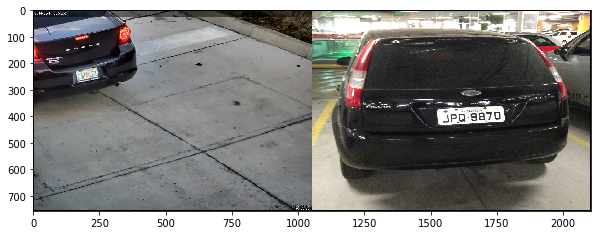

In [8]:
from torchvision.utils import make_grid
from matplotlib.patches import Rectangle

image_ex = example_train[0]
bbox_ex = example_train[1]

# Unnomalization
image_temp = torch.zeros_like(image_ex)
for i, im in enumerate(image_ex):
    image_temp[i] = transforms.Normalize(mean=(-mean/std).tolist(), std=(1/std).tolist())(im)
    
grid = make_grid(image_temp)
grid_numpy = np.array(grid).transpose(1,2,0)

plt.figure(figsize=(10,10))
plt.imshow(grid_numpy)

#plt.gca().add_patch(Rectangle((bbox_ex[0][0][0], bbox_ex[0][0][1]), 50, 50, linewidth=1, edgecolor='r'))

## bbox 확인

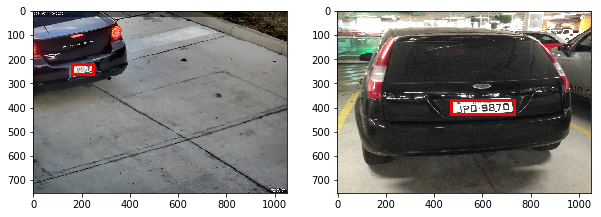

In [9]:
plt.figure(figsize = (10,10))

for i, (img, bbox) in enumerate(zip(image_temp, bbox_ex)):
    plt.subplot(2,2,i+1)
    plt.imshow(np.array(img).transpose(1,2,0))
    plt.gca().add_patch(Rectangle((bbox[0][0], bbox[0][1]), bbox[0][2], bbox[0][3], linewidth=3, edgecolor='r', facecolor='none'))

# Modeling
우선 예시로 Faster-RCNN을 이용

In [11]:
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [12]:
model = fasterrcnn_resnet50_fpn(pretrained=True)
#in_features = model.roi_heads.box_predictor.cls_score.in_features
#model.roi_heads.box_predictor = FastRCNNPredictor(in_features)

model

FasterRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d()
          )
  

### model forward test

In [14]:
model.eval()

images, boxes = next(iter(trainloader))
labels = torch.zeros((4, 1))
print(images.shape, boxes.shape, labels.shape)

x = [images[0]]
predictions = model(x)
predictions

torch.Size([2, 3, 753, 1050]) torch.Size([2, 1, 4]) torch.Size([4, 1])
5
torch.Size([1, 3, 200, 280])


[{'boxes': tensor([[6.0282e+00, 5.5758e+02, 1.0869e+02, 6.1135e+02],
          [7.7394e-01, 5.6476e+02, 4.6766e+01, 6.1019e+02],
          [4.7046e+01, 5.5986e+02, 1.1520e+02, 5.9964e+02],
          [4.9632e+02, 1.0923e+01, 8.8832e+02, 2.1840e+02],
          [4.7037e+02, 1.3984e+02, 8.3974e+02, 2.4097e+02],
          [9.6517e+02, 4.4184e+02, 1.0091e+03, 4.6587e+02],
          [1.3493e+02, 5.5601e+01, 1.4827e+02, 7.7050e+01],
          [0.0000e+00, 6.0844e+02, 3.3358e+01, 6.3115e+02],
          [5.0896e+02, 1.4931e+02, 7.0134e+02, 2.3421e+02],
          [2.4543e+02, 5.8007e+02, 2.7314e+02, 5.9711e+02],
          [7.7812e+02, 1.7663e+02, 8.3421e+02, 2.3015e+02],
          [4.7156e+02, 1.7982e+00, 9.1490e+02, 4.1382e+02],
          [5.0254e+02, 1.6590e+02, 5.5358e+02, 2.1451e+02],
          [0.0000e+00, 6.1011e+02, 3.3228e+01, 6.3049e+02]],
         grad_fn=<StackBackward>),
  'labels': tensor([ 3,  3,  3,  3,  3,  3, 37,  3,  3, 16, 10,  3, 10, 81]),
  'scores': tensor([0.8124, 0.5691, 0

In [ ]:
### plt.figure(figsize=(10,10))
image_temp = torch.zeros_like(images[0])
image_temp = transforms.Normalize(mean=(-mean/std).tolist(), std=(1/std).tolist())(images[0])
    
plt.imshow(np.array(image_temp).transpose(1,2,0))

for i, s in enumerate(predictions[0]['scores']):
    if s > 0:
        b = predictions[0]['boxes'][i]
        x = b[0]
        y = b[1]
        w = b[2]-b[0]
        h = b[3]-b[1]
        plt.gca().add_patch(Rectangle((x,y), w, h, linewidth=1, edgecolor='r', facecolor='none'))

# Training

from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection import FasterRCNN
from torchvision.models import mobilenet_v2

backbone = mobilenet_v2(pretrained=True).features
backbone.out_channels = 1280

anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512)),
                                   aspect_ratios=((0.5, 1.0, 2.0)))

roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=[0],
                                                output_size=7,
                                                sampling_ratio=2)

model = FasterRCNN(backbone,
                   num_classes=2,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)

model.eval()






In [ ]:
image_path = 'data/image/face_example4.jpeg'

In [ ]:
img = Image.open('data/image/face_example4.jpeg')
plt.imshow(img)
print(img.size)

In [ ]:
model = MTCNN(
    image_size = 200,
    margin = 100,
    keep_all = True
)

In [ ]:
model(img)

In [ ]:
output = model(img)
output.shape

In [ ]:
plt.figure(figsize = (10,10))

for i in range(output.shape[0]):
    plt.subplot(2,2,i+1)
    plt.imshow(output[i].permute(1,2,0))

In [ ]:
plt.imshow(output.permute(1,2,0))

In [ ]:

help(MTCNN)

In [ ]:
model = MTCNN()
plt.imshow(np.array(model(img).permute(1,2,0)))